# Quebec new motor vehicle sales

This notebook attempts to forecast the number of units sold of new motor vehicles in Quebec using a seasonal ARIMA model. 

References:

Introduction to ARIMA models  
https://people.duke.edu/~rnau/411arim.htm

A Guide to Time Series Forecasting with ARIMA in Python 3  
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

Dataset:

New motor vehicle sales (Statistics Canada)  
https://open.canada.ca/data/en/dataset/0decc62b-3047-417c-81e7-d8f96fac09a9

In [1]:
import requests
import tempfile
import zipfile
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from os.path import join
sns.set()
warnings.filterwarnings('ignore')

/usr/local/envs/py3env/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Preparation

In [2]:
# Download, unzip and read the data
url = r'https://www150.statcan.gc.ca/n1/tbl/csv/20100001-eng.zip'
req = requests.get(url)
with tempfile.TemporaryFile() as f:
  f.write(req.content)
  with zipfile.ZipFile(f, 'r') as z:
    with tempfile.TemporaryDirectory() as d:
      z.extractall(d)
      df = pd.read_csv(join(d, '20100001.csv'))

In [3]:
# Convert REF_DATE to datetime and set it as the index
df['REF_DATE'] = pd.to_datetime(df['REF_DATE'])
df = df.set_index('REF_DATE')

In [4]:
# Geography values
pd.DataFrame(df['GEO'].unique(), columns=['GEO'])

,GEO
0,Canada
1,Newfoundland and Labrador
2,Prince Edward Island
3,Nova Scotia
4,New Brunswick
5,Quebec
6,Ontario
7,Manitoba
8,Saskatchewan
9,Alberta


In [5]:
# Vehicle type values
pd.DataFrame(df['Vehicle type'].unique(), columns=['Vehicle type'])

,Vehicle type
0,"Total, new motor vehicles"
1,Passenger cars
2,Trucks


In [6]:
# Origin of manufacture values
pd.DataFrame(df['Origin of manufacture'].unique(), columns=['Origin of manufacture'])

,Origin of manufacture
0,"Total, country of manufacture"
1,North America
2,"Total, overseas"
3,Japan
4,Other countries


In [7]:
# Seasonal adjustment values
pd.DataFrame(df['Seasonal adjustment'].unique(), columns=['Seasonal adjustment'])

,Seasonal adjustment
0,Unadjusted
1,Seasonally adjusted


In [8]:
# Filter Quebec new motor vehicle sales from 2000 to date
filter = (df['Vehicle type'] == 'Passenger cars') & \
         (df['Sales'] == 'Units') & \
         (df['Origin of manufacture'] == 'Total, country of manufacture') & \
         (df['Seasonal adjustment'] == 'Unadjusted') & \
         (df['GEO'] == 'Quebec') & \
         (df.index >= '2000-01-01')

# Apply filter and rename columns
quebec = df \
        .loc[filter, ['GEO', 'VALUE']] \
        .rename(columns={'GEO': 'Geography', 'VALUE': 'Units'})

# Rename the index
quebec.index.rename('Date', inplace=True)

In [9]:
# Utility function to plot time series
# https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3
def tsplot(y, lags=None, figsize=(12, 7), title='Time Series Analysis Plots'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
        
    y.plot(ax=ts_ax)
    p_value = sm.tsa.adfuller(y)[1]
    ts_ax.set_title('{0}\n Dickey-Fuller: p-value={1:.5f}'.format(title, p_value))
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

## Data Exploration

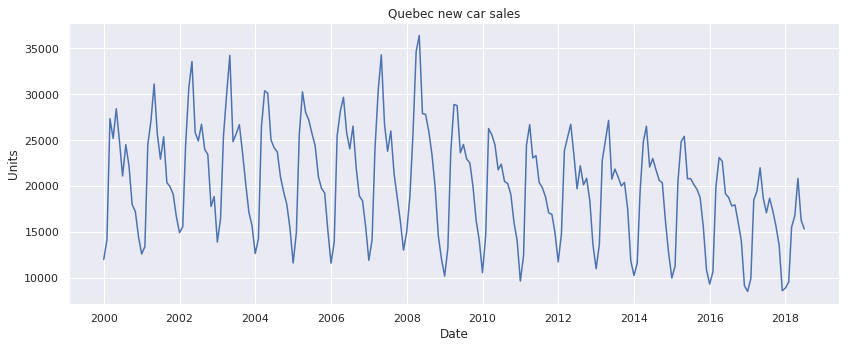

In [10]:
# Plot the time series to visualize its characteristics
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.lineplot(x=quebec.index, y='Units', data=quebec, ax=ax)
ax.set_title('Quebec new car sales')
plt.tight_layout()
plt.show()

The time series shows a clear seasonal pattern as well as some variance between each season. A slight downward trend is also apparent. Applying a log transformation will reduce the variance. 

Let's plot the result after the log transformation as well as the autocorrelation and partial autocorrelation.

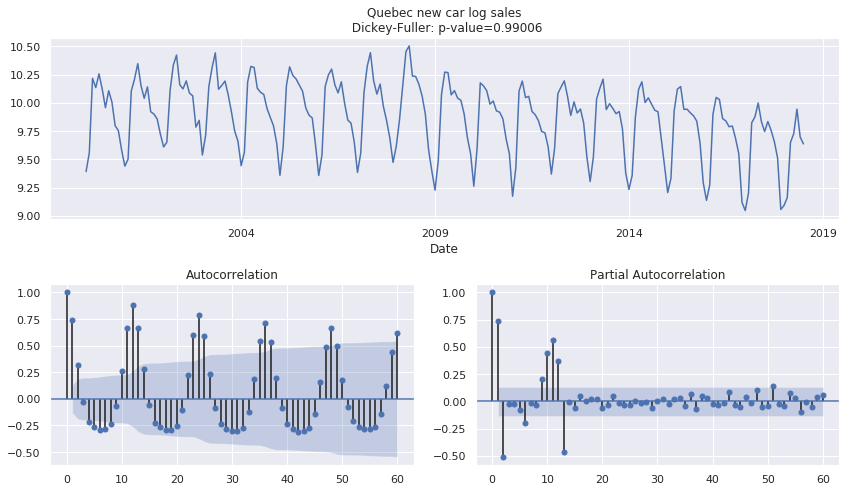

In [11]:
# Apply a log transformation on units to reduce variance
quebec['Units_log'] = np.log(quebec['Units'])

# Plot the series and its autocorrelations
tsplot(quebec['Units_log'], lags=60, title='Quebec new car log sales')

The autocorrelation plot shows that the seasonal period is 12 months. The p-value of 0.99006 of the Dickey-Fuller test indicates that the time series is not stationary. In order to identify the parameters for the ARIMA model, the time series needs to be made stationary by applying a seasonal difference. 

Let's plot the time series after differencing and let's calculate the standard deviation.

Standard deviation=0.09761


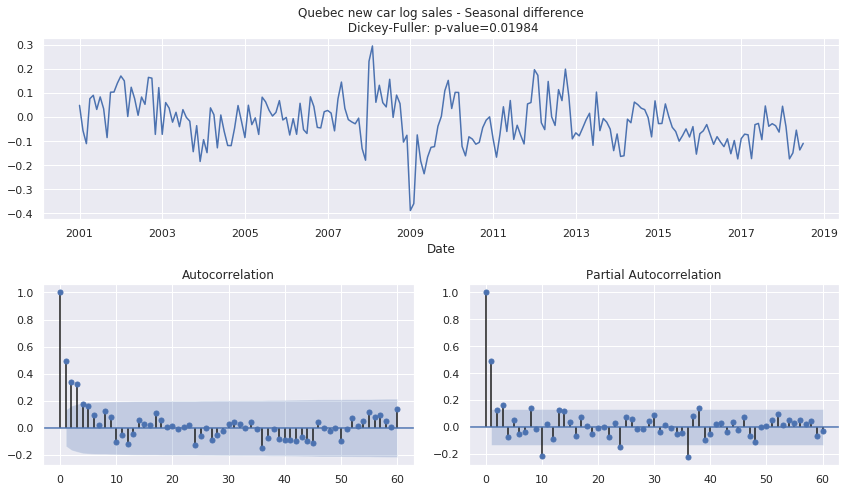

In [12]:
# Apply seasonal difference
quebec['Units_log_sdiff'] = quebec['Units_log'].diff(12)

# Drop the NaN produced by the seasonal difference
quebec = quebec.dropna()

# Plot the autocorrelations to verify stationarity
tsplot(quebec['Units_log_sdiff'], lags=60, title='Quebec new car log sales - Seasonal difference')

# Print the standard deviation of the series
print('Standard deviation={0:.5f}'.format(quebec['Units_log_sdiff'].std()))

The p-value of 0.01984 of the Dickey-Fuller test indicates that the time series is now stationary, however the positive value of the first lag in the autocorrelation plot indicates that the time series might be "underdifferenced". Some of the lags in the partial autocorrelation plot are significant. 

Let's apply the first difference of the seasonal difference to verify if the time series becomes more stationary and if the number of significant lags is reduced in the partial autocorrelation plot. Let's also calculate the standard deviation of the so that we can compare it with the previous difference (in general the optimal order of differencing is when the standard deviation is the lowest).

Standard deviation=0.09833


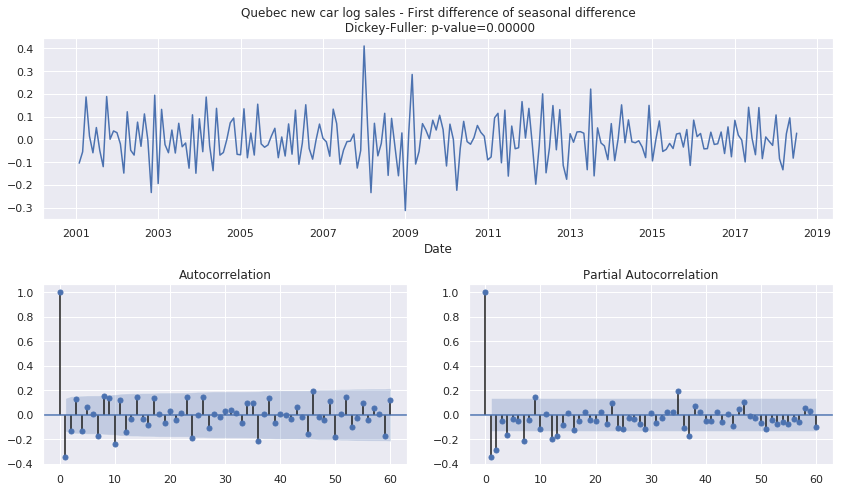

In [13]:
# Apply first difference of seasonal difference
quebec['Units_log_sdiff_diff'] = quebec['Units_log_sdiff'].diff()

# Drop the NaN produced by the seasonal difference
quebec = quebec.dropna()

# Plot the autocorrelations to verify stationarity
tsplot(quebec['Units_log_sdiff_diff'].dropna(), lags=60, 
       title='Quebec new car log sales - First difference of seasonal difference')

# Print the standard deviation of the series
print('Standard deviation={0:.5f}'.format(quebec['Units_log_sdiff_diff'].dropna().std()))

he p-value of 0.00000 of the Dickey-Fuller test indicates that the time series is now more stationary, the negative value of the first lag of the autocorrelation plot indicates mild "overdifferencing". The standard deviation is slightly higher than the previous differencing. It is not clear if both regular and seasonal differencing would be required in the ARIMA model. We will need to compare two models to verify with order of differencing produces better forecasts.

## SARIMAX(1, 0, 0)x(0, 1, 0, 12)

Let's start with a model that applies only the seasonal difference and contains only 1 AR term and assumes a constant trend. Let's print a summary of the model after fitting it as well as a diagnostic plot of the residuals to analyse the model.

In [14]:
# Fit a model with 1 seasonal difference, 1 AR term and a constant trend
model_a = sm.tsa.statespace.SARIMAX(
  quebec['Units'], 
  order=(1, 0, 0), 
  seasonal_order=(0, 1, 0, 12),
  enforce_stationarity=False,
  enforce_invertibility=False,
  trend='c'
)
result_a = model_a.fit()
result_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Units   No. Observations:                  210
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood               -1744.933
Date:                            Tue, 25 Sep 2018   AIC                           3495.867
Time:                                    02:50:28   BIC                           3505.908
Sample:                                02-01-2001   HQIC                          3499.926
                                     - 07-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -241.9320    127.166     -1.902      0.057    -491.172       7.308
ar.L1          0.4703      0.057      8.279      0.000       0.359       0.582
sigma2      2.891e+06   2.67e+05     10.815      0.000    2.37e+06    3.42e+06
===================================================================================
Ljung-Box (Q):                      101.33   Jarque-Bera (JB):                 3.06
Prob(Q):                              0.00   Prob(JB):                         0.22
Heteroskedasticity (H):               0.46   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

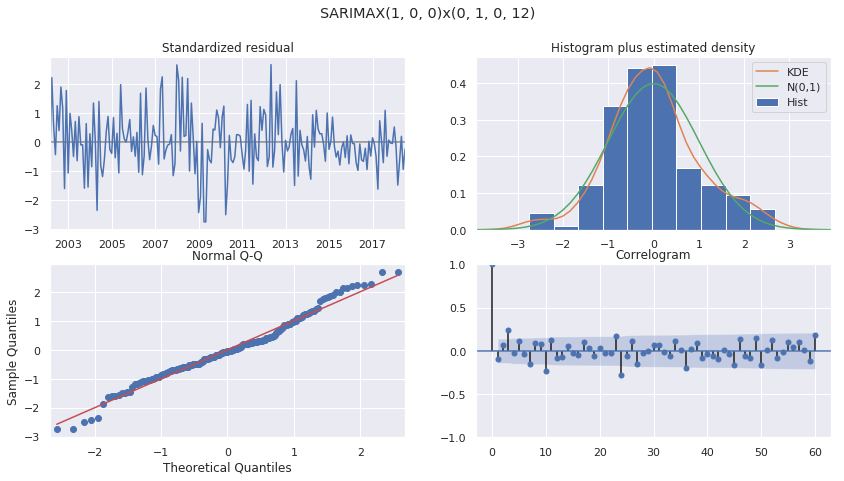

In [15]:
# Plot diagnostics on the residuals to verify model fit
fig = result_a.plot_diagnostics(figsize=(14, 7), lags=60)
fig.suptitle('SARIMAX(1, 0, 0)x(0, 1, 0, 12)')
plt.show()

The model seems to produce a good fit. The "ar.L1" coeficient is significant and the residuals are mostly normally distributed. The correlogram shows a bit of autocorrelation though.

Let's produce one-step ahead forecasts to validate the acurracy of the forecasts.

In [16]:
# Produce one-step ahead forecasts to validate the acurracy of the forecasts
pred_a = result_a.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_a_ci = pred_a.conf_int()

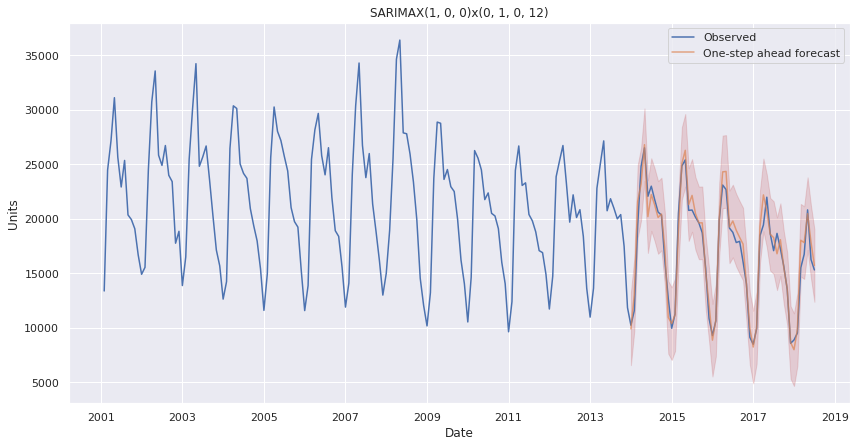

In [17]:
# Plot the one-step ahead forecasts and the confidence interval
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
quebec['Units'].plot(label='Observed', ax=ax)
pred_a.predicted_mean.plot(label='One-step ahead forecast', ax=ax, alpha=.7)
ax.fill_between(pred_a_ci.index,
                pred_a_ci.iloc[:, 0],
                pred_a_ci.iloc[:, 1], color='r', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Units')
ax.set_title('SARIMAX(1, 0, 0)x(0, 1, 0, 12)')
plt.legend()
plt.show()

In [18]:
# Calculate the RMSE for comparison with the alternative model
rmse = sm.tools.eval_measures.rmse(quebec.loc['2014-01-01':, 'Units'], pred_a.predicted_mean)
print('RMSE = {}'.format(round(rmse, 2)))

RMSE = 1072.67


## SARIMAX(0, 1, 1)x(0, 1, 1, 12)

Let's compare the previous model with a model that applies the seasonal difference, a regular difference, contains only 1 MA term and assumes no constant trend. Let's print a summary of the model after fitting it as well as a diagnostic plot of the residuals to analyse the model.

In [19]:
# Fit a model with 1 seasonal difference, 1 first difference, 1 MA term and no constant trend
model_b = sm.tsa.statespace.SARIMAX(
  quebec['Units'], 
  order=(0, 1, 1), 
  seasonal_order=(0, 1, 1, 12),
  enforce_stationarity=False,
  enforce_invertibility=False
)
result_b = model_b.fit()
result_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Units   No. Observations:                  210
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1620.043
Date:                            Tue, 25 Sep 2018   AIC                           3246.085
Time:                                    02:50:29   BIC                           3256.127
Sample:                                02-01-2001   HQIC                          3250.145
                                     - 07-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5723      0.061     -9.356      0.000      -0.692      -0.452
ma.S.L12      -0.5652      0.068     -8.262      0.000      -0.699      -0.431
sigma2      3.074e+06   2.96e+05     10.377      0.000    2.49e+06    3.66e+06
===================================================================================
Ljung-Box (Q):                      150.48   Jarque-Bera (JB):                 3.94
Prob(Q):                              0.00   Prob(JB):                         0.14
Heteroskedasticity (H):               0.42   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

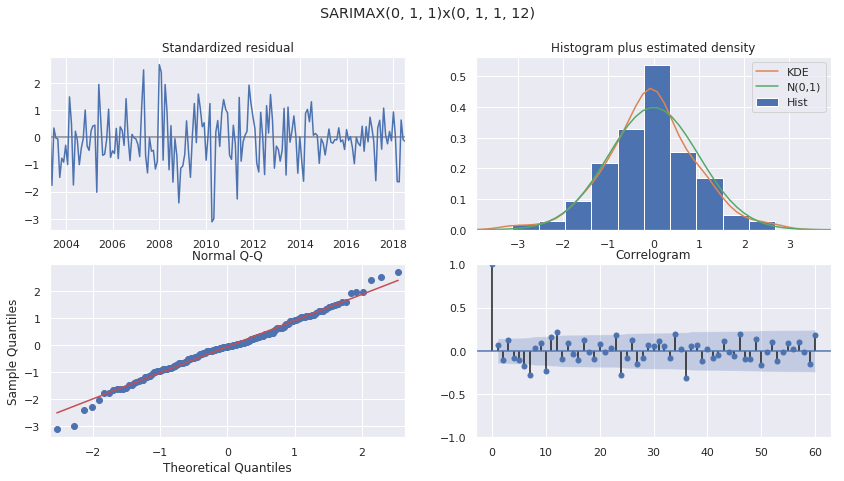

In [20]:
# Plot diagnostics on the residuals to verify model fit
fig = result_b.plot_diagnostics(figsize=(14, 7), lags=60)
fig.suptitle('SARIMAX(0, 1, 1)x(0, 1, 1, 12)')
plt.show()

The model also seems to produce a good fit. The "ma.L1" and "ma.S.L12" coeficients are significant and the residuals are mostly normally distributed. For this model the correlogram also shows a bit of autocorrelation.

Let's produce one-step ahead forecasts to validate the acurracy of the forecasts.

In [21]:
# Produce one-step ahead forecasts to validate the acurracy of the forecasts
pred_b = result_b.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred_b_ci = pred_b.conf_int()

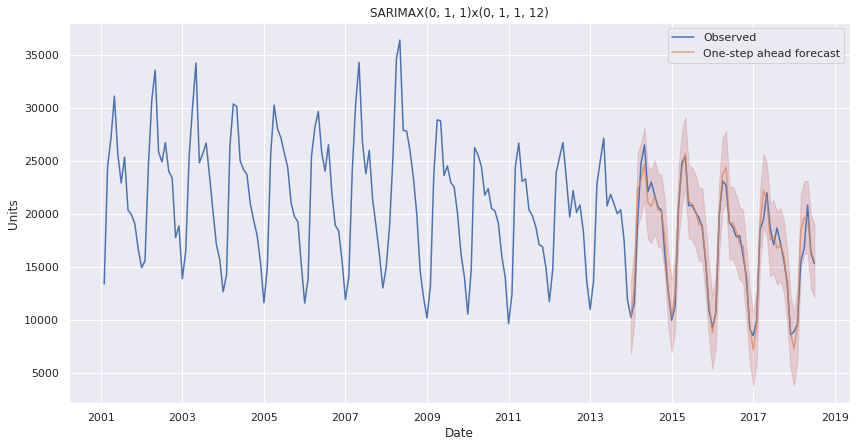

In [22]:
# Plot the one-step ahead forecasts and the confidence interval
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
quebec['Units'].plot(label='Observed', ax=ax)
pred_b.predicted_mean.plot(label='One-step ahead forecast', ax=ax, alpha=.7)
ax.fill_between(pred_b_ci.index,
                pred_b_ci.iloc[:, 0],
                pred_b_ci.iloc[:, 1], color='r', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Units')
ax.set_title('SARIMAX(0, 1, 1)x(0, 1, 1, 12)')
plt.legend()
plt.show()

In [23]:
# Calculate the RMSE for comparison with the alternative model
rmse = sm.tools.eval_measures.rmse(quebec.loc['2014-01-01':, 'Units'], pred_b.predicted_mean)
print('RMSE = {}'.format(round(rmse, 2)))

RMSE = 1138.42


## Model Selection and Final Forecasts

Although the RMSE for the "SARIMAX(1, 0, 0)x(0, 1, 0, 12)" model is slightly lower than the "SARIMAX(0, 1, 1)x(0, 1, 1, 12)" model, the lower AIC coefficient for the "SARIMAX(0, 1, 1)x(0, 1, 1, 12)" indicates a better fit. However, both models are quite close to each other in terms of accuracy.

The prediction intervals for the "SARIMAX(1, 0, 0)x(0, 1, 0, 12)" are narrower because it assumes a constant trend, while the prediction intervals for the "SARIMAX(0, 1, 1)x(0, 1, 1, 12)" are wider because it assumes a more variable trend.

In [24]:
# Produce dynamic forecasts for the SARIMAX(1, 0, 0)x(0, 1, 0, 12) model
forecast_a = result_a.get_forecast(steps=48)
forecast_a_ci = forecast_a.conf_int()

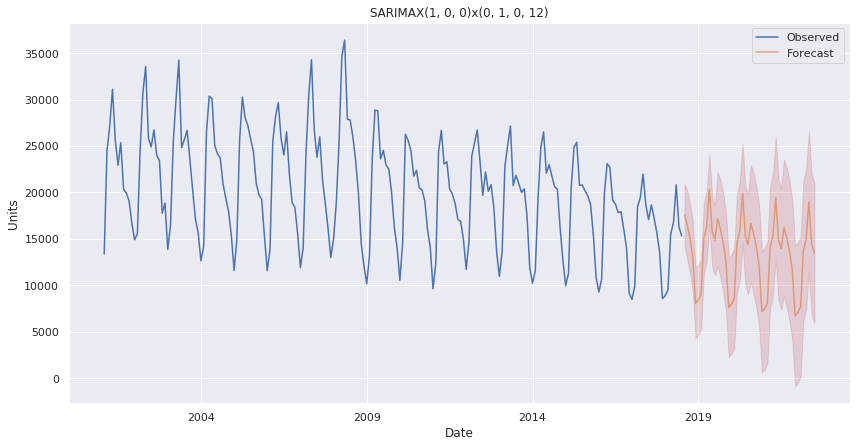

In [25]:
# Plot the dynamic forecasts for the SARIMAX(1, 0, 0)x(0, 1, 0, 12) model
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
quebec['Units'].plot(label='Observed', ax=ax)
forecast_a.predicted_mean.plot(label='Forecast', ax=ax, alpha=.7)
ax.fill_between(forecast_a_ci.index,
                forecast_a_ci.iloc[:, 0],
                forecast_a_ci.iloc[:, 1], color='r', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Units')
ax.set_title('SARIMAX(1, 0, 0)x(0, 1, 0, 12)')
plt.legend()
plt.show()

In [26]:
# Produce dynamic forecasts for the SARIMAX(0, 1, 1)x(0, 1, 1, 12) model
forecast_b = result_b.get_forecast(steps=48)
forecast_b_ci = forecast_b.conf_int()

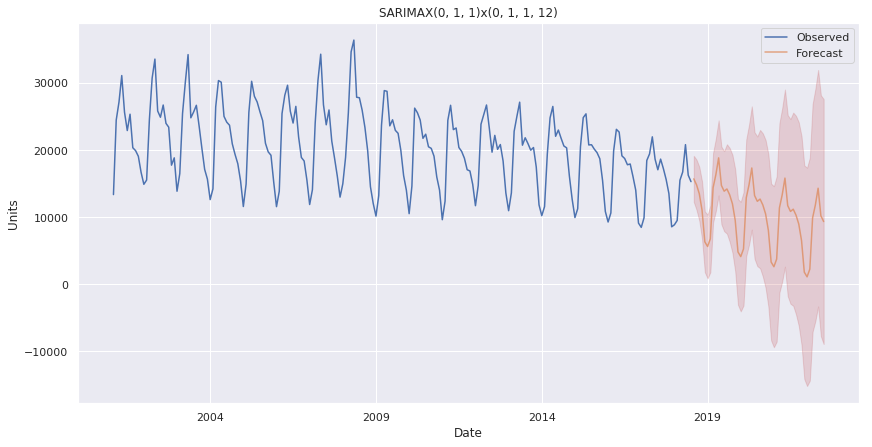

In [27]:
# Plot the dynamic forecasts for the SARIMAX(0, 1, 1)x(0, 1, 1, 12) model
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
quebec['Units'].plot(label='Observed', ax=ax)
forecast_b.predicted_mean.plot(label='Forecast', ax=ax, alpha=.7)
ax.fill_between(forecast_b_ci.index,
                forecast_b_ci.iloc[:, 0],
                forecast_b_ci.iloc[:, 1], color='r', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Units')
ax.set_title('SARIMAX(0, 1, 1)x(0, 1, 1, 12)')
plt.legend()
plt.show()